## Gaussian Mixture Model and EM Algorithm

### Introduction to Gaussian Mixture Model
Gaussian Mixture Models (GMMs) are probabilistic models that assume **all the data points are generated from a mixture of several Gaussian distributions** with unknown parameters. The key element for the implementation of Gaussian Mixture Model is the **Expectation-Maximization Algorithm**.

A *Gaussian Mixture* is a function that is comprised of several Gaussians, each identified by $k ∈ {1,…, K}$, where $K$ is the number of clusters of our dataset. Each Gaussian $k$ in the mixture is comprised of the following parameters:

* A mean $μ$ that defines its centre.
* A covariance $Σ$ that defines its width. This would be equivalent to the dimensions of an ellipsoid in a multivariate scenario.
* A mixing probability $π$ that defines how big or small the Gaussian function will be.

<img src='pic/gmm.png' width=600>


### Expectation-Maximization Algorithm
Expectataion-Maximization (EM) Algorithm is an **iterative algorithm** to find the maximum likelihood when there are latent variables. For simplicity, the illustration below will be a binary clustering problem.

Assume that all the data points are created via two different Gaussian Distribution. Here we randomly initialize two distribution with variables:

$$\theta := \phi, \mu_1, \mu_2, \Sigma_1, \Sigma_2$$

where $\phi$ is the probabilitity of the data that belongs to the second cluster, $\mu_1$ and $\mu_2$ be the mean value respectively, and $\Sigma_1$ and $\Sigma_2$ be the variance value respectively.

Two key steps for this algorithm are:

* **Expectation (E) step**: assign each datas point to a cluster probabilistically via a heuristic of the posterior distribution and the log-likelihood using the current estimate for the parameters

<img src='pic/estep.png' width=600>

* **Maximization (M) step**: compute and update parameters of the distribution by maximizing the expected log-likelihood from the previous E step.

<img src='pic/mstep.png' width=600>

<img src='pic/mstep2.png' width=600>

This process continues iteratively, which means that the parameter-estimates from M step are then used in the next E step.

## Gaussian Mixture Model Implementation

In [173]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
from sklearn.metrics import adjusted_rand_score

In [97]:
iris = load_iris()
X = iris.data ## drop the label for this unsupervised learning problem

### ManualGMM

In [99]:
class ManualGMM:
    def __init__(self, k, max_iter = 10):
        self.k = k
        self.max_iter = int(max_iter)
    
    def initialize(self, X):
        """
        Randomly initialize parameters for two gaussian distributions.
        
        Parameters
        --------
        X: dataframe
        """
        self.n, self.m = X.shape
        self.shape = X.shape
        
        self.phi = np.full(shape = self.k, fill_value = np.random.normal(0, 1))
        self.weights = np.full(shape = self.shape, fill_value =  np.random.normal(0, 1))
        random_row = np.random.randint(low=0, high=self.n, size=self.k)
        self.mu = [X[row_index,:] for row_index in random_row]
        self.sigma = [ np.cov(X.T) for _ in range(self.k) ]
    
    def e_step(self, X):
        """
        Perform Expectation steps for the algorithm.
        
        Parameters
        --------
        X: dataframe
        """
        self.weights = self.predict_proba(X)
        self.phi = self.weights.mean(axis=0)
    
    def m_step(self, X):
        """
        Perform Maximization steps for the algorithm.
        
        Parameters
        --------
        X: dataframe
        """
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()
            self.mu[i] = (X * weight).sum(axis=0) / total_weight
            self.sigma[i] = np.cov(X.T, 
                                   aweights=(weight/total_weight).flatten(),
                                   bias=True)
    
    def fit(self, X):
        """
        Fit the Gaussian Mixture Model.
        
        Parameters
        --------
        X: dataframe
        """
        self.initialize(X)
        
        for iter in range(self.max_iter):
            self.e_step(X)
            self.m_step(X)
    
    def predict_proba(self, X):
        """
        Predict probability of a class for the data point.
        
        Parameters
        --------
        X: dataframe
        """
        likelihood = np.zeros((self.n, self.k))
        for i in range(self.k):
            distribution = multivariate_normal(
                mean=self.mu[i], 
                cov=self.sigma[i],
                allow_singular=True)
            likelihood[:, i] = distribution.pdf(X)
        
        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        return weights
    
    def predict(self, X):
        """
        Predict the class for the data point.
        
        Parameters
        --------
        X: dataframe
        """
        weights = self.predict_proba(X)
        return np.argmax(weights, axis=1)

In [174]:
manual_gmm = ManualGMM(k=len(set(iris.target)), max_iter=1000)
manual_gmm.fit(X)
y_pred_manual = manual_gmm.predict(X)
print("Rand Score for ManualGMM: ", adjusted_rand_score(iris.target, y_pred_manual))

Rand Score for ManualGMM:  0.6006861021484542


### Helper Function for Plotting

In [178]:
def jitter(x):
    """
    Helper function to jitter data point for better visualization
    
    Parameters
    --------
    x: (x,y), data point
    """
    return x + np.random.uniform(low=-0.03, high=0.03, size=x.shape)

def create_plotting_grid(features):
    """
    Helper function to create grid for plotting.
    
    Parameters
    --------
    features: list, feature list for the dataset
    """
    grid = []
    for i, x in enumerate(features):
        for j, y in enumerate(features):
            if i != j and i > j:
                grid.append((i,j))
    return grid

def plot_paired_result(X, features, prediction, n_col):
    """
    Helper function for plotting.
    
    Parameters
    --------
    features: list, feature list for the dataset
    prediction: int, predicted label 
    n_col: int, # of cols for plotting
    """
    
    grid = create_plotting_grid(features)
    n_rows = len(grid) // n_col
    n_cols = n_col
    plt.figure(figsize=(16, 10))
    
    ## Plot paired results from the axis
    for index, (x_axis, y_axis) in enumerate(grid):
        plt.subplot(n_rows, n_cols, index+1)
        plt.title('GMM Clusters' ,size=14)
        plt.xlabel(iris.feature_names[x_axis])
        plt.ylabel(iris.feature_names[y_axis])
        plt.scatter(
            jitter(X[:, x_axis]), 
            jitter(X[:, y_axis]), 
            c = prediction, 
            cmap = 'Set2',
            marker='x')
    plt.tight_layout()

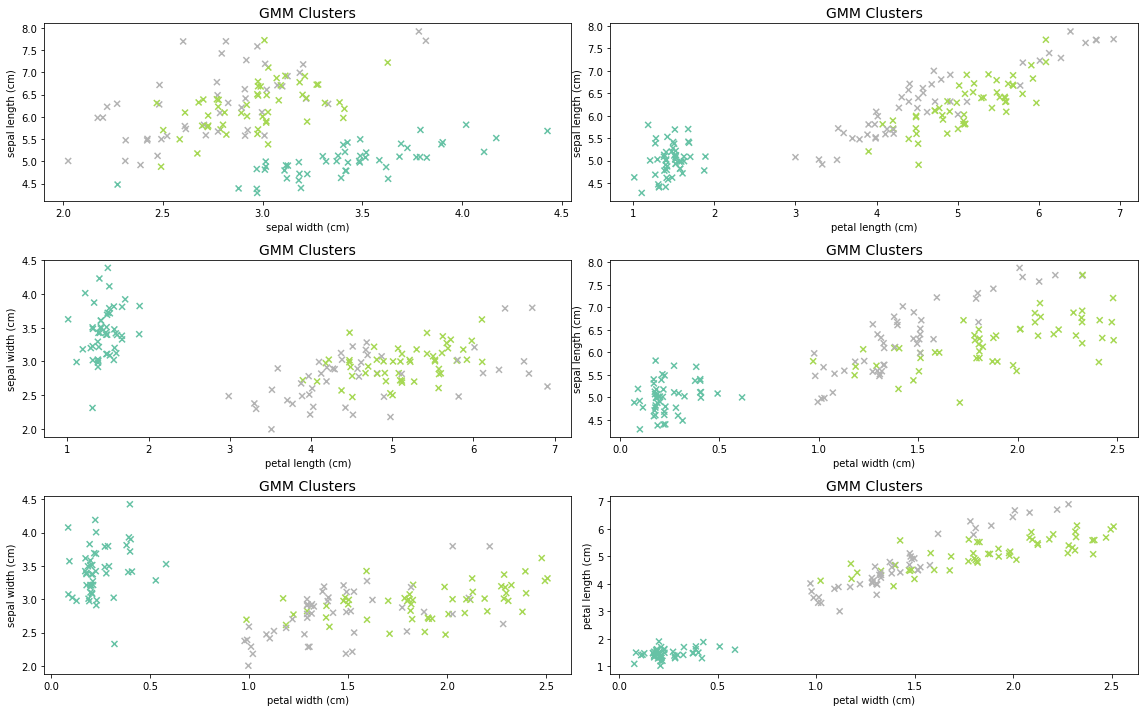

In [179]:
plot_paired_result(
    X = X,
    features = iris.feature_names,
    prediction = y_pred_manual,
    n_col = 2)

### Sklearn GMM

In [180]:
gmm = GaussianMixture(n_components=len(set(iris.target)), max_iter=100)
gmm.fit(X)
y_pred_sklearn = gmm.predict(X)
print("Rand Score for Sklearn GMM: ", adjusted_rand_score(iris.target, y_pred_sklearn))

Rand Score for Sklearn GMM:  0.9038742317748124


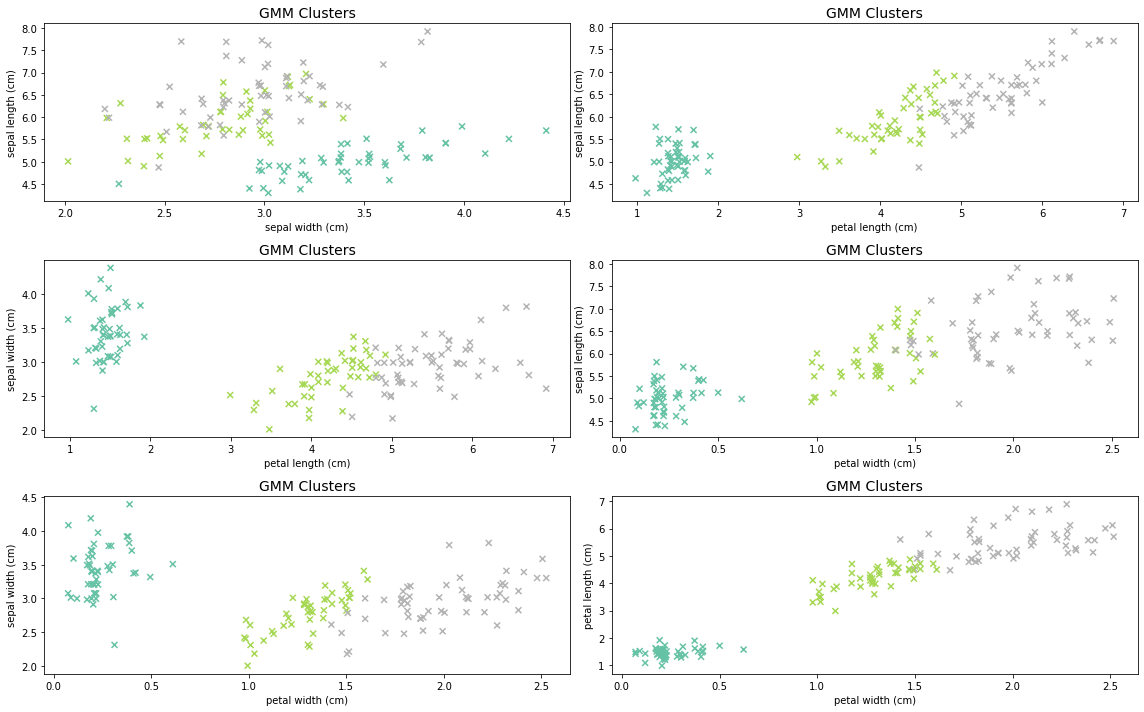

In [181]:
plot_paired_result(
    X = X,
    features = iris.feature_names,
    prediction = y_pred_sklearn,
    n_col = 2)

### Notes on Gaussian Mixture Model

* **K-Means vs Gaussian Mixture Model**: 
    * K-Means is a **hard-clustering algorithm**, which means that each data point will be assigned to only one cluster; Gaussian Mixture Model is a **soft-clustering algorithm**, with probabilities of belonging to different clusters assigned to each data point.
    * K-Means algorithm can encounter problems **when the choice of K is not well suited for the data**, while the choice of GMM's covariance matrices affects what shapes the components can take on.
    
<img src='pic/gmmvskmeanss.png' width=800>


* The **probabilistic formulation** of GMM gives a way to **handle missing data** (e.g. using the expectation maximization algorithm typically used to fit GMMs). We can still cluster a data point, even if we haven't observed its value along some dimensions. 

### Reference

[Gaussian Mixture Models Explained](https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95)

[Adjusted Rand Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)

[Implement Expectation-Maximization Algorithm(EM) in Python from Scratch](https://towardsdatascience.com/implement-expectation-maximization-em-algorithm-in-python-from-scratch-f1278d1b9137)

[ML From Scratch, Part 5: Gaussian Mixture Models](http://www.oranlooney.com/post/ml-from-scratch-part-5-gmm/)

[Questions revolving GMM & EM](https://stats.stackexchange.com/questions/126295/questions-revolving-gmm-em)

[Why use a Gaussian mixture model?](https://stats.stackexchange.com/questions/395905/why-use-a-gaussian-mixture-model)